In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


/Users/clara/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# List of tickers
tickers = ['FXAIX','FSPGX','FOCPX','FSELX','FGRIX','FBNDX','FAGIX','FFRHX','FBALX']

[*********************100%***********************]  9 of 9 completed
Optimal Portfolio Weights:
FXAIX: 0.00
FSPGX: 0.00
FOCPX: 0.09
FSELX: 0.74
FGRIX: 0.00
FBNDX: 0.00
FAGIX: 0.17
FFRHX: 0.00
FBALX: 0.00
Expected Annual Return: 10.03%
Expected Annual Volatility: 8.79%
Sharpe Ratio: 1.14


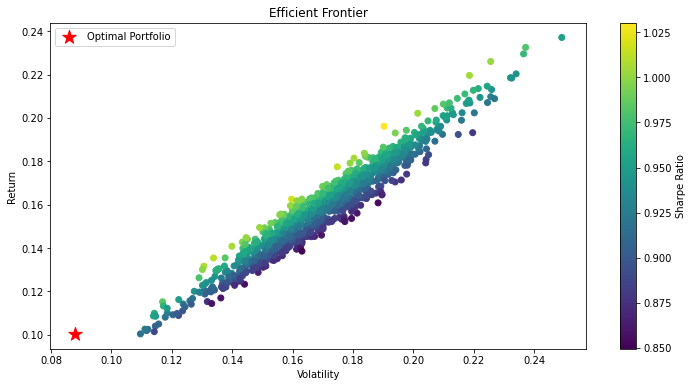

In [2]:
# Fetch historical price data from Yahoo Finance
def get_price_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Calculate daily returns from price data
def calculate_daily_returns(data):
    return data.pct_change().dropna()

# Calculate portfolio returns and volatility
def portfolio_performance(weights, returns):
    port_return = np.sum(returns.mean() * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = port_return / port_volatility
    return port_return, port_volatility, sharpe_ratio

# Objective function for optimization
def negative_sharpe_ratio(weights, returns):
    return -portfolio_performance(weights, returns)[2]

# Optimization to find optimal portfolio weights
def find_optimal_portfolio(returns):
    num_assets = len(returns.columns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    result = minimize(negative_sharpe_ratio, initial_guess, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Main function
def main():
    start_date = '2019-01-01'
    end_date = '2023-08-01'
    data = get_price_data(tickers, start_date, end_date)
    returns = calculate_daily_returns(data)

    # Find optimal portfolio weights
    optimal_weights = find_optimal_portfolio(returns)

    # Calculate portfolio performance
    opt_return, opt_volatility, opt_sharpe_ratio = portfolio_performance(optimal_weights, returns)

    print("Optimal Portfolio Weights:")
    for ticker, weight in zip(tickers, optimal_weights):
        print(f"{ticker}: {weight:.2f}")

    print(f"Expected Annual Return: {opt_return:.2%}")
    print(f"Expected Annual Volatility: {opt_volatility:.2%}")
    print(f"Sharpe Ratio: {opt_sharpe_ratio:.2f}")

    # Generate random portfolios for efficient frontier
    num_portfolios = 1000
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        ret, vol, sr = portfolio_performance(weights, returns)
        results[0, i] = ret
        results[1, i] = vol
        results[2, i] = sr

    # Plot efficient frontier
    plt.figure(figsize=(12, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(opt_volatility, opt_return, c='red', marker='*', s=200, label='Optimal Portfolio')
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    main()
